In [125]:
import os

import numpy as np

import scipy
import scipy.io
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.preprocessing

import h5py

import torch
import torch.nn as nn

from tqdm import tqdm as tqdm

from torch.utils.tensorboard import SummaryWriter

import librosa
import librosa.display
import IPython.display

from abc import abstractmethod
from torch.utils.data import Dataset, DataLoader

In [126]:
def notch_filtering(ecog, frequency):
    ecog_filtered = ecog
    for w0 in [50, 100, 150]:
        norch_b, norch_a = scipy.signal.iirnotch(w0, Q=10, fs=frequency)
        ecog_filtered = scipy.signal.filtfilt(norch_b, norch_a, ecog_filtered, axis=0)
    return ecog_filtered

def extract_sound_log_envelope(sound, frequency):
    LOW_PASS_FREQUENCY = 200
    HIGH_PASS_FREQUENCY = 200
    blp, alp = scipy.signal.butter(3, LOW_PASS_FREQUENCY / (frequency / 2), btype='low', analog=False)
    bhp, ahp = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (frequency / 2), btype='high', analog=False)
    sound_filtered  = scipy.signal.filtfilt(bhp, ahp, sound);
    envelope = scipy.signal.filtfilt(blp, alp, np.log(np.abs(sound_filtered)))
    return envelope

def sound_hpf(sound, frequency):
    HIGH_PASS_FREQUENCY = 200
    bhp, ahp = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (frequency / 2), btype='high', analog=False)
    sound_filtered  = scipy.signal.filtfilt(bhp, ahp, sound);
    return sound_filtered

def envelope_signals(signals):
    enveloped_signals = np.zeros(signals.shape)
    for i in range(signals.shape[1]):
        enveloped_signals[:, i] = np.abs(scipy.signal.hilbert(signals[:, i]))
    return enveloped_signals

def remove_eyes_artifacts(ecog, frequency):
    HIGH_PASS_FREQUENCY = 20
    bgamma, agamma = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (frequency / 2), btype='high')
    return scipy.signal.filtfilt(bgamma, agamma, ecog, axis=0)

In [128]:
# original data
DATA_FOLDER = 'C:/Workspace/PatientData/Procenko/records_03112021'
FILES_LIST = [
    f'{DATA_FOLDER}/Patient001_test0042021.03.11_19.12.59.hdf5',
    f'{DATA_FOLDER}/Patient001_test0052021.03.11_19.26.24.hdf5',
    f'{DATA_FOLDER}/Patient001_test0062021.03.11_19.42.41.hdf5',
    f'{DATA_FOLDER}/Patient001_test0072021.03.11_20.40.02.hdf5',
    f'{DATA_FOLDER}/Patient001_test0082021.03.11_20.55.25.hdf5',
    f'{DATA_FOLDER}/Patient001_test0092021.03.11_21.10.53.hdf5',
            ]
FREQUENCY = 19200

# prepare ecog data
left_remove_index = np.array([0, 0, 5, 10, 0.5, 1.5])*FREQUENCY
DOWNSAMPLING_COEF = 10
output_filepath = 'C:/Workspace/NeuralSignal/datasets/data_preprocessed.hdf5'
create_output = not os.path.exists(output_filepath)


if create_output:
    for i, filepath in tqdm(enumerate(FILES_LIST)):

        # open one of the files with expe
        with h5py.File(filepath,'r+') as input_file:
            data = input_file['RawData']['Samples'][()]
            ecog = (data[:, :30]).astype("float64")
            sound = (data[:, 31]).astype("float64")
            del data

        # remove unrelated data, downsample, filter, scale, and convert to 'float32'
        ecog = ecog[int(left_remove_index[i]):,:]
        ecog = scipy.signal.decimate(ecog, DOWNSAMPLING_COEF, axis=0)
        ecog = remove_eyes_artifacts(ecog, FREQUENCY // DOWNSAMPLING_COEF)
        ecog = notch_filtering(ecog, FREQUENCY // DOWNSAMPLING_COEF)
        ecog = sklearn.preprocessing.scale(ecog, copy=False)
        ecog = ecog.astype("float32")

        # filter >200 to remove potential ecog influence
        sound = sound_hpf(sound, FREQUENCY)
        sound = sklearn.preprocessing.scale(sound, copy=False)
        sound = sound.astype("float32")

        # save ecog in single file
        with h5py.File(output_filepath,'a') as output_file:
            subset_name = f'subset_{i}'
            output_file[subset_name + '/ecog'] = ecog
            output_file[subset_name + '/sound'] = sound


6it [03:19, 33.19s/it]


In [129]:
# abstract Map-style dataset class
# 
class NeuralSignalDataset(Dataset):
    def __init__(self, filepath, subsets):
        self._create_dataset(filepath, subsets)
        
    def _create_dataset(self, filepath, subsets):
        self.batches = []
        if isinstance(subsets, str):
            self.batches = self._make_batches(filepath, subsets)
        elif isinstance(subsets, (list, tuple)):
            for subset in subsets:
                self.batches += self._make_batches(filepath, subset)
                
    def _make_batches(self, filepath, subset):
        with h5py.File(filepath,'r+') as input_file:
            ecog = input_file[subset + '/ecog'][()]
            sound = input_file[subset + '/sound'][()]
        batches = self.transform_data(ecog, sound)
        return batches

    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        return self.batches[idx]
    
    @abstractmethod
    def transform_data(self, ecog, sound):
        pass

In [130]:
class NeuralSignalDatasetTS(NeuralSignalDataset):
    def __init__(self, config):
        self.config = config
        super(NeuralSignalDatasetTS, self).__init__(config['filepath'], config['subsets'])
        
    def transform_data(self, ecog, sound):
        ecog_window = self.config['ecog_window_ms'] * self.config['frequency_ecog']//1000
        ecog_lag_backward = self.config['ecog_lag_backward_ms'] * self.config['frequency_ecog']//1000
        ecog_lag_forward = self.config['ecog_lag_forward_ms'] * self.config['frequency_ecog']//1000
        total_window = ecog_lag_backward + ecog_window + ecog_window
        sound_window = self.config['sound_window_ms'] * self.config['frequency_sound']//1000
        
        nbatch = (ecog.shape[0] - total_window) // ecog_window + 1
        ecog_left_index = np.arange(ecog_lag_backward, ecog_lag_backward + nbatch*ecog_window, ecog_window)
        ecog_center_index = (ecog_left_index + ecog_window//2)
        sound_center_index = ecog_center_index * (self.config['frequency_sound'] // self.config['frequency_ecog'])
        sound_left_index = sound_center_index - sound_window//2
        
        batches = [(torch.FloatTensor(ecog[ecog_left_index[i] - ecog_lag_backward:ecog_left_index[i] + ecog_window + ecog_lag_forward, :]),
                   torch.FloatTensor(sound[sound_left_index[i]:sound_left_index[i] + sound_window])) for i in range(nbatch)]
        
        return batches

In [133]:
config_ts ={
    'filepath': 'C:/Workspace/NeuralSignal/datasets/data_preprocessed.hdf5',
    'subsets': 'subset_0',
    'frequency_ecog': 1920,
    'ecog_window_ms': 100,
    'ecog_lag_backward_ms': 200, 
    'ecog_lag_forward_ms': 200,
    'frequency_sound': 19200,
    'sound_window_ms': 100,
}
print(f'size of sound chunk:')
dataset = NeuralSignalDatasetTS(config_ts)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

size of sound chunk:


In [136]:
ecog_chunk, sound_chunk = dataset[51]
ecog_chunk = ecog_chunk.numpy()
sound_chunk = sound_chunk.numpy()

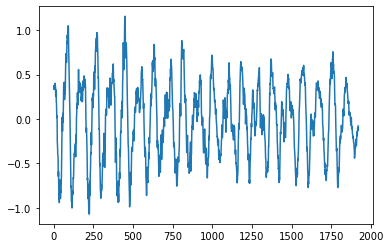

In [137]:

plt.plot(sound_chunk)
plt.show()

In [ ]:
def extract_mfccs(sound, sr, i_mel, lngt):
    S = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=16, fmax=4000, hop_length=256)
    mfccs = librosa.feature.mfcc(S = librosa.power_to_db(S), n_mfcc=16);
    the_mfcc = scipy.signal.resample(x = mfccs[i_mel,:].T, num = lngt).T;
    return the_mfcc

In [141]:
S = librosa.feature.melspectrogram(y=sound_chunk, sr=FREQUENCY, n_fft=sound_chunk.shape[0],
                                   n_mels=16, fmax=4000,hop_length=256)

In [147]:
S_dB = librosa.power_to_db(S)

C:\ProgramData\Anaconda3\envs\neural_signal\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\ProgramData\Anaconda3\envs\neural_signal\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

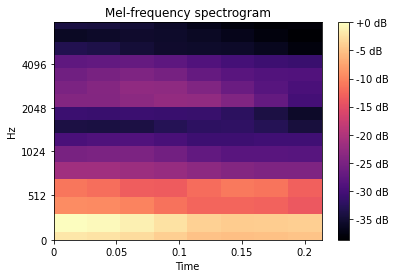

In [148]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=FREQUENCY,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
def prepare_data_ecog(filepath):
    FREQUENCY = 19200
    DOWNSAMPLING_COEF = 10
    FREQUENCY_DOWNSAMPLE = FREQUENCY // DOWNSAMPLING_COEF
    HIGH_PASS_FREQUENCY = 20
    NOTCH_FREQUENCY = (50, 100, 150)
    
    with h5py.File(filepath,'r+') as input_file:
        ecog = np.array(input_file['RawData']['Samples'][:, :30], dtype='double')

    # downsample
    ecog = scipy.signal.decimate(ecog, DOWNSAMPLING_COEF, axis=0)
    
    # remove eyes artifacts (hpf 20)
    bgamma, agamma = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (FREQUENCY_DOWNSAMPLE / 2), btype='high')
    ecog = scipy.signal.filtfilt(bgamma, agamma, ecog, axis=0)
    
    # notch for (50, 100, 150) Hz
    for w0 in NOTCH_FREQUENCY:
        norch_b, norch_a = scipy.signal.iirnotch(w0, Q=10, fs=FREQUENCY_DOWNSAMPLE)
        ecog = scipy.signal.filtfilt(norch_b, norch_a, ecog, axis=0)
        
    return ecog

In [17]:
sound = []
for filepath in tqdm(FILES_LIST):
    with h5py.File(filepath,'r+') as input_file:
        #ecog = np.array(input_file['RawData']['Samples'][:, :30], dtype='double')
        sound.append(np.array(input_file['RawData']['Samples'][:, 31], dtype='double'))


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:30<00:00, 25.14s/it]


In [6]:
FREQUENCY = 19200
DOWNSAMPLING_COEF = 10
FREQUENCY_DOWNSAMPLE = FREQUENCY // DOWNSAMPLING_COEF

X = []
Y = []

for filepath in tqdm(FILES_LIST):
    with h5py.File(filepath,'r+') as input_file:
        ecog = np.array(input_file['RawData']['Samples'][:, :30], dtype='double')
        sound = np.array(input_file['RawData']['Samples'][:, 31], dtype='double')
    
    ecog = scipy.signal.decimate(ecog, DOWNSAMPLING_COEF, axis=0)
    ecog = remove_eyes_artifacts(ecog, FREQUENCY_DOWNSAMPLE)
    ecog = notch_filtering(ecog, FREQUENCY_DOWNSAMPLE)
    
    sound_envelope = extract_mfccs(sound = sound, sr=FREQUENCY, i_mel = 1, lngt = ecog.shape[0]).T
    
    X.append(ecog)
    Y.append(sound_envelope)

X = np.concatenate(X)
Y = np.concatenate(Y).reshape((-1, 1))

X = sklearn.preprocessing.scale(X, copy=False)
Y = sklearn.preprocessing.scale(Y, copy=False)

X = X.astype("float32")
Y = Y.astype("float32")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:37<00:00, 76.29s/it]


In [7]:
def data_generator(X, Y, batch_size, lag_backward, lag_forward, shuffle=True, infinite=True):
    assert len(X)==len(Y) or len(Y)==0
    total_lag = lag_backward + lag_forward
    all_batches = math.ceil((X.shape[0] - total_lag) /batch_size)
    samples_in_last_batch = (X.shape[0] - total_lag) % batch_size
    batch = 0
    random_core = np.arange(lag_backward, X.shape[0]-lag_forward)
    while True:
        if shuffle: np.random.shuffle(random_core)
        for batch in range(all_batches):       
            batch_start = batch * batch_size
            batch_end = (batch + 1) * batch_size
            if batch_end>=len(random_core): batch_end = None
            batch_samples = random_core[batch_start : batch_end]

            batch_x = np.array([X[i - lag_backward : i + lag_forward] for i in batch_samples])
            batch_x = np.swapaxes(batch_x,1,2)

            if len(Y) > 0:
                batch_y = Y[[batch_samples]] 
                yield (batch_x, batch_y)
            else:
                yield batch_x
        
        if not infinite:
            break

In [8]:
print(f"{round(X.shape[0] / FREQUENCY_DOWNSAMPLE / 60, 1)} min")

ntr = int(X.shape[0] * 0.80)

X_test = X[ntr:]
Y_test = Y[ntr:]

X_train = X[:ntr]
Y_train = Y[:ntr]

62.5 min


In [9]:
class EnvelopeDetector(nn.Module):
    def __init__(self, in_channels):
        super(self.__class__,self).__init__()
        self.FILTERING_SIZE = 75
        self.ENVELOPE_SIZE = 75
        self.conv_filtering = nn.Conv1d(in_channels, in_channels, bias=False, kernel_size=self.FILTERING_SIZE, groups=in_channels)
        self.conv_envelope = nn.Conv1d(in_channels, in_channels, kernel_size=self.ENVELOPE_SIZE, groups=in_channels)
        self.pre_envelope_batchnorm = torch.nn.BatchNorm1d(in_channels, affine=False) 
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_filtering(x)
        x = self.pre_envelope_batchnorm(x)
        #x = self.relu(x)
        x = torch.abs(x)
        x = self.conv_envelope(x)
        return x

In [10]:

class SimpleNet(nn.Module):
    def __init__(self, in_channels, output_channels, lag_backward, lag_forward):
        super(self.__class__,self).__init__()
        self.ICA_CHANNELS = 5
        self.relu = torch.nn.Sigmoid()

        self.total_input_channels = self.ICA_CHANNELS
        self.lag_backward = lag_backward
        self.lag_forward = lag_forward

        self.final_out_features = 95

        self.ica = nn.Conv1d(in_channels, self.ICA_CHANNELS, 1)

        self.detector = EnvelopeDetector(self.ICA_CHANNELS)
        self.unmixed_batchnorm = torch.nn.BatchNorm1d(self.ICA_CHANNELS, affine=False)
        
        self.features_batchnorm = torch.nn.BatchNorm1d(self.final_out_features, affine=False)
        
        self.pre_output_features = int(self.final_out_features/2)
        
        self.not_yet_output_features = int(self.pre_output_features/2)

        self.wights_second = nn.Linear(self.final_out_features, self.pre_output_features)
        
        self.wights_third = nn.Linear(self.pre_output_features, self.not_yet_output_features)
        
        self.wights_fourth = nn.Linear(self.not_yet_output_features, output_channels)

    def forward(self, inputs):
        all_inputs = self.ica(inputs)
        #self.unmixed_channels = all_inputs.cpu().data.numpy()
        #all_inputs = self.unmixed_batchnorm(all_inputs)

        detected_envelopes = self.detector(all_inputs)

#        features  = detected_envelopes[:, :, ::10].contiguous()
        features  = detected_envelopes[:, :, 10:-10:10].contiguous()
        features = features.view(features.size(0), -1)
        #features = self.features_batchnorm(features)
        #self.pre_out = features.cpu().data.numpy()
        preoutput = self.wights_second(features)
        notyetoutput = self.wights_third(self.relu(preoutput))
        output = self.wights_fourth(self.relu(notyetoutput))
        
        return output


In [11]:
LAG_BACKWARD = 175
LAG_FORWARD = 175


BATCH_SIZE = 100

model = SimpleNet(X_train.shape[1], Y_train.shape[1], LAG_BACKWARD, LAG_FORWARD)

print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

train_generator = data_generator(X_train, Y_train, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=True, infinite=True)
test_generator = data_generator(X_test, Y_test, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=True, infinite=True)

loss_history_train = []
loss_history_test = []


Trainable params:  6550
Total params:  6550


In [12]:
def process_batch(generator, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    x_batch, y_batch = next(generator)
    assert x_batch.shape[0] == y_batch.shape[0]
    assert y_batch.shape[1] == 1
    #assert x_batch.shape[1] == 30
#    x_batch = torch.FloatTensor(x_batch).cuda()
#    y_batch = torch.FloatTensor(y_batch).cuda()
    x_batch = torch.FloatTensor(x_batch)
    y_batch = torch.FloatTensor(y_batch)

    if is_train:
        optimizer.zero_grad()

    y_predicted = model(x_batch)
    loss = loss_function(y_predicted, y_batch)

    if is_train:
        loss.backward()
        optimizer.step()


    assert y_predicted.shape[0] == y_batch.shape[0]
    assert y_predicted.shape[1] == y_batch.shape[1] == 1
    
    train_or_test = "train" if is_train else "test"

    correlation = np.corrcoef(y_predicted.cpu().detach().numpy(), y_batch.cpu().detach().numpy(), rowvar=False)[0, 1]

    #writer.add_scalar(f'{train_or_test}/loss', loss.cpu().detach().numpy(), iteration)
    #writer.add_scalar(f'{train_or_test}/correlation', correlation, iteration)
    
    if is_train:
        loss_history_train.append(correlation)
    else:
        loss_history_test.append(correlation)

In [13]:
for iteration in tqdm(range(30_000)):
    process_batch(train_generator, True)
    with torch.no_grad():
        process_batch(test_generator, False)
        
    if iteration % 250 == 0:
        eval_lag = min(1000, iteration)
        print(f"Train loss: {np.mean(loss_history_train[-eval_lag:])}")
        print(f"Test loss: {np.mean(loss_history_test[-eval_lag:])}")
        print("#")
        
    if iteration % 5000 == 0:
        torch.save(model.state_dict(), "speech_net")
        
        
Y_predicted = []
Y_batch = []


  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]<ipython-input-7-fa77fa0ca644>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  batch_y = Y[[batch_samples]]
  0%|                                                                              | 6/30000 [00:02<2:17:37,  3.63it/s]

Train loss: -0.04856301161258295
Test loss: 0.07225945747879485
#


  1%|▋                                                                             | 257/30000 [00:07<11:07, 44.59it/s]

Train loss: 0.057922466294934465
Test loss: 0.044076448362644884
#


  2%|█▎                                                                            | 510/30000 [00:13<10:54, 45.05it/s]

Train loss: 0.11082926027869928
Test loss: 0.09505563985844627
#


  3%|█▉                                                                            | 756/30000 [00:18<11:04, 44.03it/s]

Train loss: 0.13959517795192097
Test loss: 0.12865574368451063
#


  3%|██▌                                                                          | 1005/30000 [00:24<11:41, 41.32it/s]

Train loss: 0.17232326824163657
Test loss: 0.1662330573658129
#


  4%|███▏                                                                         | 1256/30000 [00:30<10:53, 44.01it/s]

Train loss: 0.23743021991634475
Test loss: 0.23235396934406546
#


  5%|███▊                                                                         | 1508/30000 [00:36<11:27, 41.45it/s]

Train loss: 0.2807401449901994
Test loss: 0.27812412262035036
#


  6%|████▌                                                                        | 1756/30000 [00:42<11:30, 40.91it/s]

Train loss: 0.3228094712283115
Test loss: 0.3128488948203441
#


  7%|█████▏                                                                       | 2006/30000 [00:48<10:58, 42.51it/s]

Train loss: 0.34602678459159425
Test loss: 0.3309097121532746
#


  8%|█████▊                                                                       | 2255/30000 [00:54<11:11, 41.34it/s]

Train loss: 0.3589160991058142
Test loss: 0.34117326324749364
#


  8%|██████▍                                                                      | 2506/30000 [00:59<10:20, 44.30it/s]

Train loss: 0.3670420371232136
Test loss: 0.3444847305101697
#


  9%|███████                                                                      | 2758/30000 [01:05<10:05, 45.02it/s]

Train loss: 0.3716914136884642
Test loss: 0.34841724454436324
#


 10%|███████▋                                                                     | 3009/30000 [01:11<10:29, 42.87it/s]

Train loss: 0.3741037490056834
Test loss: 0.3506449688369297
#


 11%|████████▎                                                                    | 3258/30000 [01:17<10:15, 43.42it/s]

Train loss: 0.3769558070038464
Test loss: 0.3551541410658626
#


 12%|█████████                                                                    | 3507/30000 [01:23<10:18, 42.82it/s]

Train loss: 0.38112171695214125
Test loss: 0.3611856001569619
#


 13%|█████████▋                                                                   | 3756/30000 [01:28<09:39, 45.29it/s]

Train loss: 0.3813326814532098
Test loss: 0.36658656873290785
#


 13%|██████████▎                                                                  | 4007/30000 [01:34<09:58, 43.47it/s]

Train loss: 0.3863763384029892
Test loss: 0.3667415763041363
#


 14%|██████████▉                                                                  | 4256/30000 [01:40<10:33, 40.62it/s]

Train loss: 0.38895308516529603
Test loss: 0.36352970608362284
#


 15%|███████████▌                                                                 | 4505/30000 [01:46<10:59, 38.63it/s]

Train loss: 0.3883616453349099
Test loss: 0.3625065223179724
#


 16%|████████████▏                                                                | 4757/30000 [01:52<10:41, 39.33it/s]

Train loss: 0.3918445463165967
Test loss: 0.36194330112861517
#


 17%|████████████▊                                                                | 5007/30000 [01:58<10:40, 38.99it/s]

Train loss: 0.3950923925859805
Test loss: 0.3641189870973452
#


 18%|█████████████▍                                                               | 5258/30000 [02:04<09:58, 41.34it/s]

Train loss: 0.39916812598651097
Test loss: 0.3675834771270247
#


 18%|██████████████▏                                                              | 5505/30000 [02:10<09:55, 41.14it/s]

Train loss: 0.4031989606229842
Test loss: 0.36841508943670487
#


 19%|██████████████▊                                                              | 5755/30000 [02:16<09:40, 41.74it/s]

Train loss: 0.4035293461309285
Test loss: 0.3684647655352229
#


 20%|███████████████▍                                                             | 6008/30000 [02:22<09:19, 42.89it/s]

Train loss: 0.4066294213337457
Test loss: 0.36714973074509083
#


 21%|████████████████                                                             | 6259/30000 [02:28<09:21, 42.31it/s]

Train loss: 0.40624326220142376
Test loss: 0.36925236127932165
#


 22%|████████████████▋                                                            | 6507/30000 [02:34<09:36, 40.72it/s]

Train loss: 0.40896510180745327
Test loss: 0.37037033277798936
#


 23%|█████████████████▎                                                           | 6759/30000 [02:40<08:49, 43.89it/s]

Train loss: 0.4115356933025656
Test loss: 0.37406599170173194
#


 23%|█████████████████▉                                                           | 7008/30000 [02:46<09:11, 41.72it/s]

Train loss: 0.4108164931278124
Test loss: 0.3745467691146704
#


 24%|██████████████████▋                                                          | 7259/30000 [02:52<09:08, 41.47it/s]

Train loss: 0.41645423999401276
Test loss: 0.3726213058681048
#


 25%|███████████████████▎                                                         | 7506/30000 [02:58<08:29, 44.12it/s]

Train loss: 0.4153190476231553
Test loss: 0.37145552214906713
#


 26%|███████████████████▉                                                         | 7758/30000 [03:04<08:52, 41.81it/s]

Train loss: 0.4162883434431452
Test loss: 0.36596404857112613
#


 27%|████████████████████▌                                                        | 8007/30000 [03:10<08:13, 44.55it/s]

Train loss: 0.41674031445190474
Test loss: 0.36592926583332847
#


 28%|█████████████████████▏                                                       | 8256/30000 [03:16<08:42, 41.59it/s]

Train loss: 0.4166524665170731
Test loss: 0.367557586458527
#


 28%|█████████████████████▊                                                       | 8507/30000 [03:22<08:38, 41.46it/s]

Train loss: 0.41813763549133054
Test loss: 0.37145891152124394
#


 29%|██████████████████████▍                                                      | 8756/30000 [03:27<07:55, 44.64it/s]

Train loss: 0.41662663291133184
Test loss: 0.375573034343362
#


 30%|███████████████████████                                                      | 9008/30000 [03:33<08:30, 41.14it/s]

Train loss: 0.41736057324555315
Test loss: 0.3776243030126644
#


 31%|███████████████████████▊                                                     | 9259/30000 [03:39<08:04, 42.81it/s]

Train loss: 0.41552316653864774
Test loss: 0.3815884359906541
#


 32%|████████████████████████▍                                                    | 9506/30000 [03:45<08:01, 42.52it/s]

Train loss: 0.41783536275276717
Test loss: 0.3850534049544066
#


 33%|█████████████████████████                                                    | 9757/30000 [03:51<08:00, 42.10it/s]

Train loss: 0.423673618785492
Test loss: 0.3844572446409105
#


 33%|█████████████████████████▎                                                  | 10005/30000 [03:57<07:44, 43.01it/s]

Train loss: 0.4219788261435071
Test loss: 0.38534436728276605
#


 34%|█████████████████████████▉                                                  | 10255/30000 [04:03<08:16, 39.78it/s]

Train loss: 0.42277169301967665
Test loss: 0.38147081582729925
#


 35%|██████████████████████████▌                                                 | 10508/30000 [04:09<07:44, 41.99it/s]

Train loss: 0.42369986011777394
Test loss: 0.381449728543827
#


 36%|███████████████████████████▎                                                | 10758/30000 [04:15<07:57, 40.26it/s]

Train loss: 0.4213369311624152
Test loss: 0.38681225310505646
#


 37%|███████████████████████████▉                                                | 11005/30000 [04:21<09:12, 34.35it/s]

Train loss: 0.4236102269532886
Test loss: 0.3892444848222617
#


 38%|████████████████████████████▌                                               | 11257/30000 [04:28<07:46, 40.21it/s]

Train loss: 0.42078990348946965
Test loss: 0.39201972352907466
#


 38%|█████████████████████████████▏                                              | 11508/30000 [04:34<07:10, 42.96it/s]

Train loss: 0.4218302670516424
Test loss: 0.3912562562850611
#


 39%|█████████████████████████████▊                                              | 11756/30000 [04:40<07:11, 42.33it/s]

Train loss: 0.42068926552584823
Test loss: 0.3872957912544249
#


 40%|██████████████████████████████▍                                             | 12006/30000 [04:45<07:13, 41.50it/s]

Train loss: 0.4189864298319534
Test loss: 0.3871345272895709
#


 41%|███████████████████████████████                                             | 12257/30000 [04:52<07:35, 38.91it/s]

Train loss: 0.4238863098155694
Test loss: 0.3861019757963721
#


 42%|███████████████████████████████▋                                            | 12504/30000 [04:57<07:35, 38.43it/s]

Train loss: 0.4233858014266601
Test loss: 0.384604034744049
#


 43%|████████████████████████████████▎                                           | 12759/30000 [05:03<07:02, 40.79it/s]

Train loss: 0.42731689852732296
Test loss: 0.3858439946020026
#


 43%|████████████████████████████████▉                                           | 13004/30000 [05:09<06:34, 43.12it/s]

Train loss: 0.4288635760822052
Test loss: 0.38717037264018245
#


 44%|█████████████████████████████████▌                                          | 13259/30000 [05:15<06:58, 39.98it/s]

Train loss: 0.4277960107338823
Test loss: 0.3885678239764352
#


 45%|██████████████████████████████████▏                                         | 13507/30000 [05:21<06:33, 41.96it/s]

Train loss: 0.4312609295429361
Test loss: 0.39011993316878646
#


 46%|██████████████████████████████████▊                                         | 13758/30000 [05:27<06:35, 41.06it/s]

Train loss: 0.43008390238836813
Test loss: 0.38962578485100746
#


 47%|███████████████████████████████████▍                                        | 14008/30000 [05:33<06:25, 41.54it/s]

Train loss: 0.42951248058366387
Test loss: 0.38726357604740247
#


 48%|████████████████████████████████████▏                                       | 14260/30000 [05:39<06:04, 43.18it/s]

Train loss: 0.4290672909988888
Test loss: 0.3875054659966464
#


 48%|████████████████████████████████████▊                                       | 14510/30000 [05:45<05:39, 45.63it/s]

Train loss: 0.42538338651636937
Test loss: 0.38788568917977717
#


 49%|█████████████████████████████████████▍                                      | 14758/30000 [05:51<06:06, 41.61it/s]

Train loss: 0.42585946052934853
Test loss: 0.3897928726390274
#


 50%|██████████████████████████████████████                                      | 15007/30000 [05:56<05:41, 43.97it/s]

Train loss: 0.4275677317408414
Test loss: 0.3906758440025462
#


 51%|██████████████████████████████████████▋                                     | 15258/30000 [06:02<05:28, 44.88it/s]

Train loss: 0.4253133344008349
Test loss: 0.3923643671412575
#


 52%|███████████████████████████████████████▎                                    | 15510/30000 [06:08<05:24, 44.63it/s]

Train loss: 0.42484416108243395
Test loss: 0.39016968790656825
#


 53%|███████████████████████████████████████▉                                    | 15757/30000 [06:14<05:36, 42.34it/s]

Train loss: 0.4256651813480279
Test loss: 0.39095683443444956
#


 53%|████████████████████████████████████████▌                                   | 16005/30000 [06:20<05:28, 42.64it/s]

Train loss: 0.4295420241143432
Test loss: 0.3928541308650208
#


 54%|█████████████████████████████████████████▏                                  | 16258/30000 [06:25<05:06, 44.87it/s]

Train loss: 0.4340181578265715
Test loss: 0.39328212842550747
#


 55%|█████████████████████████████████████████▊                                  | 16506/30000 [06:31<05:19, 42.27it/s]

Train loss: 0.4385591421047339
Test loss: 0.3973796285176155
#


 56%|██████████████████████████████████████████▍                                 | 16754/30000 [06:37<05:16, 41.90it/s]

Train loss: 0.43978406711641244
Test loss: 0.39905903705391305
#


 57%|███████████████████████████████████████████                                 | 17008/30000 [06:43<05:03, 42.77it/s]

Train loss: 0.4364149978593159
Test loss: 0.403871869054729
#


 58%|███████████████████████████████████████████▋                                | 17257/30000 [06:49<04:57, 42.76it/s]

Train loss: 0.4376409751208646
Test loss: 0.4011265917615143
#


 58%|████████████████████████████████████████████▎                               | 17507/30000 [06:55<04:53, 42.51it/s]

Train loss: 0.4382987864454452
Test loss: 0.4009472040116687
#


 59%|████████████████████████████████████████████▉                               | 17758/30000 [07:01<04:53, 41.68it/s]

Train loss: 0.4377154221350538
Test loss: 0.3997577315173744
#


 60%|█████████████████████████████████████████████▌                              | 18006/30000 [07:06<04:35, 43.51it/s]

Train loss: 0.442192559108792
Test loss: 0.3986454512932129
#


 61%|██████████████████████████████████████████████▏                             | 18256/30000 [07:12<04:21, 44.84it/s]

Train loss: 0.44316260960702164
Test loss: 0.40431422020696245
#


 62%|██████████████████████████████████████████████▉                             | 18506/30000 [07:18<04:44, 40.38it/s]

Train loss: 0.44256324410930137
Test loss: 0.40756577949186307
#


 63%|███████████████████████████████████████████████▌                            | 18756/30000 [07:24<04:12, 44.61it/s]

Train loss: 0.4448598734032759
Test loss: 0.4070741638808115
#


 63%|████████████████████████████████████████████████▏                           | 19010/30000 [07:30<04:18, 42.51it/s]

Train loss: 0.4436723752654116
Test loss: 0.4046452319828493
#


 64%|████████████████████████████████████████████████▊                           | 19256/30000 [07:36<04:30, 39.72it/s]

Train loss: 0.442643538182761
Test loss: 0.40348002219833834
#


 65%|█████████████████████████████████████████████████▍                          | 19506/30000 [07:42<04:11, 41.76it/s]

Train loss: 0.4435403332289469
Test loss: 0.39804072701339577
#


 66%|██████████████████████████████████████████████████                          | 19757/30000 [07:47<03:58, 42.94it/s]

Train loss: 0.44257784513481035
Test loss: 0.3997653302629577
#


 67%|██████████████████████████████████████████████████▋                         | 20006/30000 [07:54<03:50, 43.45it/s]

Train loss: 0.4431038746908228
Test loss: 0.40036548497894753
#


 68%|███████████████████████████████████████████████████▎                        | 20255/30000 [07:59<04:05, 39.62it/s]

Train loss: 0.4428152336476835
Test loss: 0.4004764268959308
#


 68%|███████████████████████████████████████████████████▉                        | 20506/30000 [08:05<03:31, 44.93it/s]

Train loss: 0.4428777775175316
Test loss: 0.4020515842170331
#


 69%|████████████████████████████████████████████████████▌                       | 20758/30000 [08:11<03:32, 43.55it/s]

Train loss: 0.44376716868790494
Test loss: 0.4039156670388124
#


 70%|█████████████████████████████████████████████████████▏                      | 21006/30000 [08:17<03:31, 42.54it/s]

Train loss: 0.4440264411675479
Test loss: 0.40297072917959237
#


 71%|█████████████████████████████████████████████████████▊                      | 21257/30000 [08:23<03:28, 41.88it/s]

Train loss: 0.4482049974765737
Test loss: 0.4020819216403286
#


 72%|██████████████████████████████████████████████████████▍                     | 21506/30000 [08:28<03:14, 43.61it/s]

Train loss: 0.4467146812799636
Test loss: 0.4024690559781958
#


 73%|███████████████████████████████████████████████████████                     | 21757/30000 [08:34<03:17, 41.79it/s]

Train loss: 0.4490088867196066
Test loss: 0.40081923231832517
#


 73%|███████████████████████████████████████████████████████▋                    | 22006/30000 [08:40<03:02, 43.79it/s]

Train loss: 0.4497831430999759
Test loss: 0.4009823965085928
#


 74%|████████████████████████████████████████████████████████▍                   | 22255/30000 [08:46<03:14, 39.85it/s]

Train loss: 0.44740913992176484
Test loss: 0.40270848270825466
#


 75%|█████████████████████████████████████████████████████████                   | 22507/30000 [08:52<02:52, 43.48it/s]

Train loss: 0.4474398989663352
Test loss: 0.40590555692071884
#


 76%|█████████████████████████████████████████████████████████▋                  | 22759/30000 [08:58<02:56, 41.11it/s]

Train loss: 0.44535253351063236
Test loss: 0.40625797778886763
#


 77%|██████████████████████████████████████████████████████████▎                 | 23007/30000 [09:03<02:41, 43.29it/s]

Train loss: 0.4470354204514084
Test loss: 0.4083159774980762
#


 78%|██████████████████████████████████████████████████████████▉                 | 23258/30000 [09:09<02:41, 41.87it/s]

Train loss: 0.4461109815074819
Test loss: 0.4119238737663659
#


 78%|███████████████████████████████████████████████████████████▌                | 23505/30000 [09:15<02:32, 42.55it/s]

Train loss: 0.4489645864505193
Test loss: 0.4113583145163346
#


 79%|████████████████████████████████████████████████████████████▏               | 23757/30000 [09:21<02:25, 42.88it/s]

Train loss: 0.4497536380990287
Test loss: 0.4119663155729256
#


 80%|████████████████████████████████████████████████████████████▊               | 24009/30000 [09:27<02:19, 42.90it/s]

Train loss: 0.44866613257757176
Test loss: 0.41397846433358426
#


 81%|█████████████████████████████████████████████████████████████▍              | 24259/30000 [09:33<02:06, 45.28it/s]

Train loss: 0.45036414126846164
Test loss: 0.40907752644661216
#


 82%|██████████████████████████████████████████████████████████████              | 24508/30000 [09:38<02:13, 41.28it/s]

Train loss: 0.4526510189193373
Test loss: 0.40466288054157973
#


 83%|██████████████████████████████████████████████████████████████▋             | 24758/30000 [09:44<02:18, 37.83it/s]

Train loss: 0.45239963898294
Test loss: 0.4034400648659613
#


 83%|███████████████████████████████████████████████████████████████▎            | 25005/30000 [09:50<01:57, 42.44it/s]

Train loss: 0.4497171856876145
Test loss: 0.40040716943959265
#


 84%|███████████████████████████████████████████████████████████████▉            | 25256/30000 [09:57<02:04, 38.17it/s]

Train loss: 0.4522305293532488
Test loss: 0.4016859545618835
#


 85%|████████████████████████████████████████████████████████████████▌           | 25505/30000 [10:03<02:04, 36.19it/s]

Train loss: 0.4517824055214178
Test loss: 0.40610501925496395
#


 86%|█████████████████████████████████████████████████████████████████▎          | 25759/30000 [10:09<01:37, 43.66it/s]

Train loss: 0.4507861489048503
Test loss: 0.4073383088449545
#


 87%|█████████████████████████████████████████████████████████████████▉          | 26010/30000 [10:15<01:33, 42.84it/s]

Train loss: 0.45444273011406716
Test loss: 0.4111964095967091
#


 88%|██████████████████████████████████████████████████████████████████▌         | 26256/30000 [10:20<01:26, 43.52it/s]

Train loss: 0.45184835721050454
Test loss: 0.4084088884939822
#


 88%|███████████████████████████████████████████████████████████████████▏        | 26508/30000 [10:26<01:20, 43.45it/s]

Train loss: 0.45070137017188805
Test loss: 0.4077762008075949
#


 89%|███████████████████████████████████████████████████████████████████▊        | 26759/30000 [10:32<01:15, 42.81it/s]

Train loss: 0.45209261123410144
Test loss: 0.40665206126024034
#


 90%|████████████████████████████████████████████████████████████████████▍       | 27009/30000 [10:38<01:08, 43.70it/s]

Train loss: 0.45122396846598
Test loss: 0.40210270149994365
#


 91%|█████████████████████████████████████████████████████████████████████       | 27256/30000 [10:44<01:03, 42.94it/s]

Train loss: 0.45276369199233996
Test loss: 0.40337160042553705
#


 92%|█████████████████████████████████████████████████████████████████████▋      | 27507/30000 [10:50<00:59, 41.92it/s]

Train loss: 0.45100786548435995
Test loss: 0.40259234246984477
#


 93%|██████████████████████████████████████████████████████████████████████▎     | 27758/30000 [10:56<00:52, 42.79it/s]

Train loss: 0.4528270033703512
Test loss: 0.4040410742869538
#


 93%|██████████████████████████████████████████████████████████████████████▉     | 28010/30000 [11:02<00:46, 42.81it/s]

Train loss: 0.45073042418703496
Test loss: 0.4080767566923407
#


 94%|███████████████████████████████████████████████████████████████████████▌    | 28255/30000 [11:07<00:39, 44.25it/s]

Train loss: 0.4473779916819838
Test loss: 0.40982126587337914
#


 95%|████████████████████████████████████████████████████████████████████████▏   | 28507/30000 [11:13<00:34, 43.65it/s]

Train loss: 0.4478510031944331
Test loss: 0.4100702801568601
#


 96%|████████████████████████████████████████████████████████████████████████▊   | 28757/30000 [11:19<00:29, 42.82it/s]

Train loss: 0.4460964011772977
Test loss: 0.41189034632897076
#


 97%|█████████████████████████████████████████████████████████████████████████▍  | 29005/30000 [11:25<00:22, 44.73it/s]

Train loss: 0.44701164126449033
Test loss: 0.4093802282993776
#


 98%|██████████████████████████████████████████████████████████████████████████  | 29259/30000 [11:30<00:17, 42.48it/s]

Train loss: 0.44995364795621423
Test loss: 0.40917544486016927
#


 98%|██████████████████████████████████████████████████████████████████████████▋ | 29506/30000 [11:36<00:11, 42.40it/s]

Train loss: 0.4522052003287159
Test loss: 0.4097548408894834
#


 99%|███████████████████████████████████████████████████████████████████████████▍| 29757/30000 [11:42<00:05, 44.55it/s]

Train loss: 0.44990901618051277
Test loss: 0.4073347005484198
#


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:48<00:00, 42.35it/s]


0it [00:00, ?it/s]<ipython-input-7-fa77fa0ca644>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  batch_y = Y[[batch_samples]]
1401it [00:02, 499.68it/s]


Correlation   val 0.6170569403061694


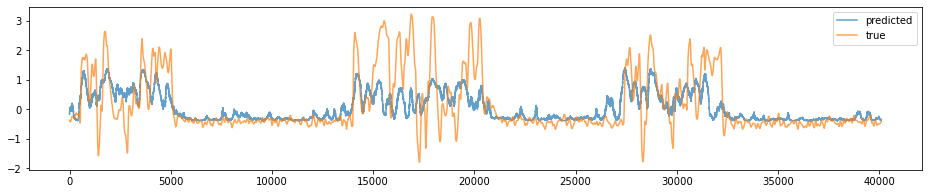

In [14]:

#model.cuda()

for index, (x_batch, y_batch) in tqdm(enumerate(data_generator(X_test, Y_test, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=False, infinite=False))):
    #### Train
    model.eval()
    
    if index < 1000:
        continue  # skip first samples
    
    if index > 1400:
        break # skip all the rest

    x_batch = torch.FloatTensor(x_batch)
    y_predicted = model(x_batch).cpu().data.numpy()
    assert x_batch.shape[0]==y_predicted.shape[0]
    Y_predicted.append(y_predicted)
    Y_batch.append(y_batch)

Y_predicted = np.concatenate(Y_predicted, axis=0)
Y_batch = np.concatenate(Y_batch, axis=0)

print("Correlation   val", np.corrcoef(Y_predicted[:, 0], Y_batch[:, 0], rowvar=False)[0,1])

plt.figure(figsize=(16, 3))
plt.plot(Y_predicted, label="predicted", alpha=0.7)
plt.plot(Y_batch, label="true", alpha=0.7)
plt.legend()
plt.show()